In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rebound as rb
import reboundx as rbx
%matplotlib inline

In [2]:
init_params=[]
init_params.append({'m': 0.0008, 'rho': 1.04534352444679,'a':0.275,'e':0.01,'inc':0 
                    }) #,'omega':np.deg2rad(176.839),'Omega':np.deg2rad(351.238),'M':np.deg2rad(251.503)})
init_params.append({'m':0.00254,'rho':1.04534352444679,'a': 0.5,'e': 0.01, 'inc':0
                   }) #,'omega': np.deg2rad(157.419),'Omega': np.deg2rad(207.477),'M':np.deg2rad(210.452)})
init_params.append({'m':5e-05,'rho':1.04534352444679,'a':0.9 ,'e':0.01,'inc':0 
                   }) #,'omega':np.deg2rad(99.629),'Omega':np.deg2rad(257.996),'M':np.deg2rad(343.739)})

In [3]:
def mod_2pi(p):
    """ Mod an angle to be between 0 and 2*pi"""
    res = p
    while res < 0:
        res += 2*np.pi
    return np.mod(res,2*np.pi)
def mod_pi(p):
    """ Mod an angle that's between -pi and pi to 0 to 2*pi"""
    return mod_2pi(p+np.pi)


In [178]:
sim = rb.Simulation()
sim.add(m=1.)
for p in init_params:
        try:
            p.pop('rho')
        except KeyError:
            pass
        sim.add(**p)
sim.move_to_com()
sim.integrator = 'WHFast'
ps = sim.particles
sim.dt = .02 #2*np.pi/ps[1].n * (1-ps[1].e)**(1.5) / 10
sim.exit_max_distance = 5.
sim.exit_min_distance = 3 * ps[2].a*np.sqrt(ps[2].m/3)

rebx = rbx.Extras(sim)
params = rebx.add_modify_orbits_direct()

tau_e = 1e3
K = 100.
sim.particles[-1].tau_a = -tau_e * K
sim.particles[-1].tau_e = -tau_e
#sim.init_megno(1e-16)

print ps[-1].tau_a, ps[-1].tau_e


-100000.0 -1000.0


In [179]:
times = np.linspace(0,1e6,1e4)
megno = np.zeros(times.shape)
lyap = np.zeros(times.shape)
energy = np.zeros(times.shape)
avals = np.zeros((len(times),3))
avalsf = np.zeros((len(times),3))
evals = np.zeros((len(times),3))
ivals = np.zeros((len(times),3))
pvals = np.zeros((len(times),3))
lapvals = np.zeros(times.shape)
dtvals = np.zeros(times.shape)


stage_one_complete = False
stage_two_complete = False
stage_one_time = 0
stage_two_time = 0
tend = times[-1]

for i,t in enumerate(times):
    try:
        sim.integrate(t*2*np.pi,exact_finish_time=0)
    except rb.Escape as error:
        print error
        tend = t
        break
    except rb.Encounter as error:
        print error
        tend = t
        break
    sim.calculate_orbits()
    if not stage_one_complete:
        if ps[-2].n/ps[-1].n <= 2.0:
            print 'Outer pair hit 2:1 resonance at t=%f' % (t*2*np.pi)
            stage_one_complete = True
            stage_one_time = t
#            ps[-2].tau_a = ps[-1].tau_a
#            ps[-2].tau_e = ps[-1].tau_e 
#             ps[-1].tau_a = np.infty
#             ps[-1].tau_e = np.infty

    if stage_one_complete and not stage_two_complete:
        if ps[-3].n/ps[-2].n <= 2.0:
            print 'Inner pair hit 2:1 resonance at t=%f' % (t*2*np.pi)
            stage_two_time = t
            ps[-1].tau_a = np.infty
            ps[-1].tau_e = np.infty
#            ps[-2].tau_a = np.infty
#            ps[-2].tau_e = np.infty
            stage_two_complete = True
#            tend = t
#            break
            sim.init_megno(1e-16)
        
    avals[i,:] = [p.a for p in ps[1:]]
    evals[i,:] = [p.e for p in ps[1:]]
    ivals[i,:] = [p.inc for p in ps[1:]]
    pvals[i,:] = [p.P for p in ps[1:]]
    lapvals[i] = mod_2pi(mod_pi(ps[1].l) - 3*mod_pi(ps[2].l) + 2*mod_pi(ps[3].l))
    megno[i] = sim.calculate_megno()
    lyap[i] = sim.calculate_lyapunov()
    energy[i] = sim.calculate_energy()
    dtvals[i] = sim.dt
ind = times<tend
p3p2 = pvals[ind,2][-1]/pvals[ind,1][-1]
p2p1 = pvals[ind,1][-1]/pvals[ind,0][-1]
print 'Final Planet Ratio:\t{:.1f} : {:.1f} : 1'.format(p3p2*p2p1,p2p1)
for i in range(len(ps[1:])):
    avalsf[:,i] = (avals[:,i]-avals[0,i])/(avals[0,i])

print 'Final Configuration:'
for i,p in enumerate(ps[1:],start=1):
    print 'i={:d}\tP={:.3f}\ta={:.3f}\te={:.3f}\ti={:.3f}\tomega={:.3f}\tOmega={:3f}\tM={:3f}'.format(i,p.P,p.a,p.e,np.rad2deg(p.inc),np.rad2deg(p.omega),np.rad2deg(p.Omega),np.rad2deg(p.M))
    

Outer pair hit 2:1 resonance at t=529725.493945
Inner pair hit 2:1 resonance at t=1359817.282202
A particle escaped (r>exit_max_distance).
Final Planet Ratio:	4.1 : 2.0 : 1
Final Configuration:
i=1	P=0.874	a=0.269	e=0.235	i=0.000	omega=-92.465	Omega=0.000000	M=-76.288306
i=2	P=1.758	a=0.428	e=0.027	i=0.000	omega=-94.254	Omega=0.000000	M=-36.695990
i=3	P=3.544	a=0.683	e=0.027	i=0.000	omega=93.640	Omega=0.000000	M=153.658370


/Users/zeus/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide


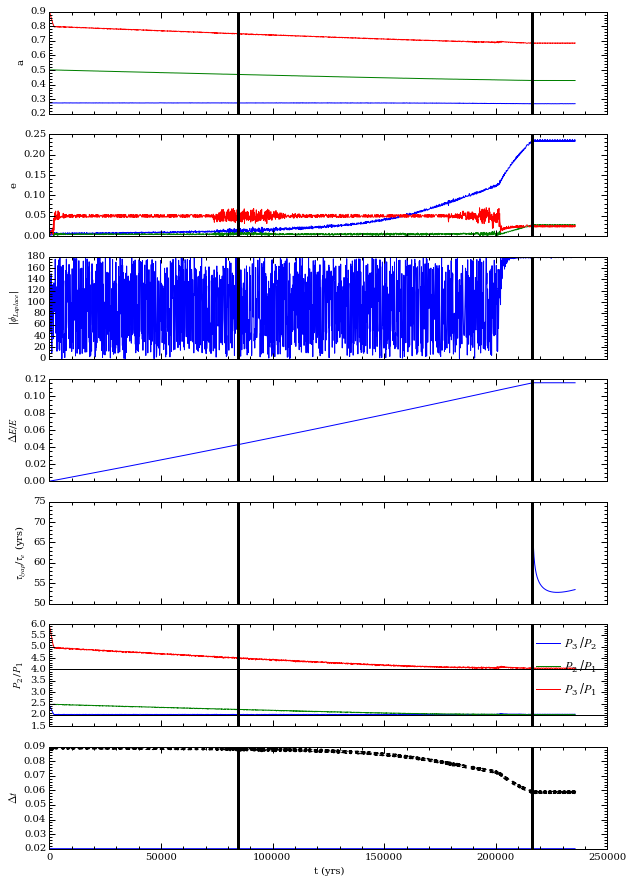

In [180]:
fig,axes=plt.subplots(7,1,sharex=True,figsize=(10,15))
axa = axes[0]
axe = axes[1]
axl = axes[2]
axE = axes[3]
axmeg = axes[4]
axper = axes[5]
axdt = axes[6]

ind = times<tend


axa.plot(times[ind],avals[ind,0],'-b',times[ind],avals[ind,1],'-g',times[ind],avals[ind,2],'-r')
axe.plot(times[ind],evals[ind,0],'-b',times[ind],evals[ind,1],'-g',times[ind],evals[ind,2],'-r')
axl.plot(times[ind],np.rad2deg(np.abs(lapvals[ind]-np.pi)))


axE.plot(times[ind],abs((energy-energy[0])/energy[0])[ind])
#axmeg.plot(times[ind],megno[ind])
#axmeg.plot(times[ind],1/lyap[ind])
axmeg.plot(times, ( 1/lyap )/tau_e)
axper.plot(times[ind],pvals[ind,2]/pvals[ind,1],'-b',label='$P_3/P_2$')
axper.plot(times[ind],pvals[ind,1]/pvals[ind,0],'-g', label='$P_2/P_1$')
axper.plot(times[ind],pvals[ind,2]/pvals[ind,0],'-r',label='$P_3/P_1$')
axa.set_ylabel('a')
axe.set_ylabel('e')
axl.set_ylabel('$|\\phi_{Laplace}|$')
axE.set_ylabel('$\\Delta E / E$')
axper.set_ylabel('$P_2/P_1$')
axmeg.set_ylabel('$\\tau_{lyap}/\\tau_e$ (yrs)')
axes[-1].set_xlabel('t (yrs)')
axper.legend(loc='upper right')
axper.axhline(4,color='k')
axper.axhline(2,color='k')

axdt.plot(times[ind],dtvals[ind])
axdt.plot(times[ind], pvals[ind,0] * (1-evals[ind,0])**(1.5) / 10,'--k',linewidth=3)
axdt.set_ylabel('$\\Delta t$')
#axes[2].set_yscale('log')
#axes[0].set_ylim(0,1)
#axes[4].set_ylim(1,3)
for ax in axes:
    ax.minorticks_on()
    ax.axvline(stage_one_time,color='k',linewidth=3)
    ax.axvline(stage_two_time,color='k',linestyle='-',linewidth=3)
#axes[0].set_xscale('log')

In [107]:
sim.t

1481664.9012278696

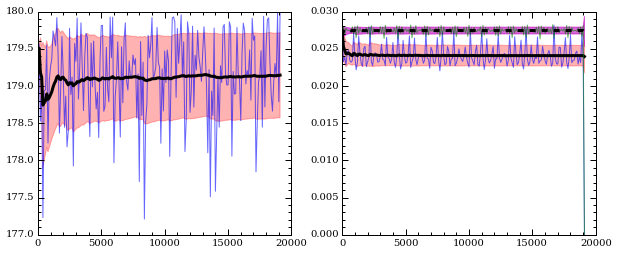

In [181]:
ind2 = (times<=tend)&(times>stage_two_time)
vals = np.abs(lapvals[ind2]-np.pi)
lp_mean = np.rad2deg(np.array([vals[times[ind2]<=x].mean() for x in times[ind2]]))
lp_std = np.rad2deg(np.array([vals[times[ind2]<=x].std() for x in times[ind2]]))

e3 = evals[ind2,2]
e_mean =  np.array([ e3[times[ind2]<=x].mean() for x in times[ind2] ])
e_std = np.array([e3[times[ind2]<=x].std() for x in times[ind2] ])

e2 = evals[ind2,1]
e2_mean =  np.array([ e2[times[ind2]<=x].mean() for x in times[ind2] ])
e2_std = np.array([e2[times[ind2]<=x].std() for x in times[ind2] ])


fig,axes=plt.subplots(1,2,figsize=(10,4))
axes[0].plot(times[ind2]-times[ind2][0],np.rad2deg(vals),'-b',alpha=.6)
axes[0].plot(times[ind2]-times[ind2][0],lp_mean,'-k',linewidth=3)
axes[0].fill_between(times[ind2]-times[ind2][0],lp_mean-lp_std,lp_mean+lp_std,color='r',alpha=.3)
axes[1].plot(times[ind2]-times[ind2][0],e3,'-b',alpha=.6)
axes[1].plot(times[ind2]-times[ind2][0],e_mean,'-k',linewidth=3)
axes[1].fill_between(times[ind2]-times[ind2][0],e_mean-e_std,e_mean+e_std,color='r',alpha=.3)
axes[1].plot(times[ind2]-times[ind2][0],e2,'-g',alpha=.6)
axes[1].plot(times[ind2]-times[ind2][0],e2_mean,'--k',linewidth=3)
axes[1].fill_between(times[ind2]-times[ind2][0],e2_mean-e2_std,e2_mean+e2_std,color='m',alpha=.6)
for ax in axes:
    
    ax.minorticks_on()

0.000395815662925


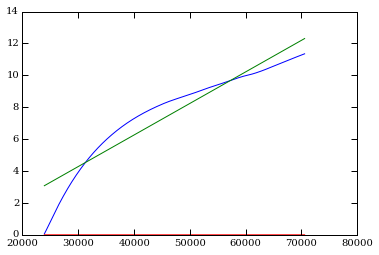

In [161]:
plt.plot(times[ind2][:-1],megno[ind2][:-1])
s = np.polyfit(times[ind2][:-1],megno[ind2][:-1],1)
plt.plot(times[ind2][:-1],times[ind2][:-1]*s[0] + s[1])
print s[0]*2


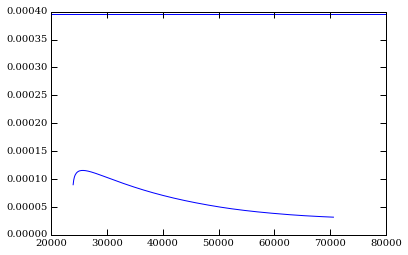

In [162]:
plt.plot(times[ind2][:-1],lyap[ind2][:-1])
plt.axhline(s[0]*2)

In [ ]:
sim.particles[1].tau_a = -1e3

In [ ]:
print sim.particles[1].tau_a

In [ ]:
rebx.add_gr()

In [ ]:
sim.integrate(100.)

In [ ]:
sim.status()